In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm


from dataset import patch_dataset
from dataset import patch_dataset_test
from trainer import train
from models import basic_FCN, UNet
import segmentation_models_pytorch as smp
import torch.nn.functional as F
from padding import pad_to_size, remove_padding

/opt/miniconda3/envs/MMD_flow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path_X = 'X_train'
file_path_Y = 'Y_train'
index = np.load('X_train/_index_good.npy')

dataset = patch_dataset(file_path_X, file_path_Y,index,load_in_ram=True, numtype=torch.float32)

In [3]:
batch_size = 64

def custom_collate(batch, mode='test'):
    padded_batch = []
    if mode == 'train':
        for image, mask in batch:
        #     print(image.shape)
        #     print(mask.shape)
        #     print(mask.unsqueeze(0).shape)
            image = pad_to_size(image, target_height=160, target_width=288)
            mask = pad_to_size(mask, target_height=160, target_width=288).squeeze(0)
            padded_batch.append((image, mask))
    
        images, masks = zip(*padded_batch)
        return torch.stack(images), torch.stack(masks)
    
    if mode == 'test':
        for image in batch:
            image = pad_to_size(image, target_height=160, target_width=288)
            padded_batch.append(image)
        return torch.stack(padded_batch)

# dataloader = DataLoader(dataset, batch_size, shuffle=True, collate_fn=custom_collate)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
model = UNet(in_channels=1, out_channels=3, features=[32, 64, 128, 256])
#model.to('mps')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = criterion = torch.nn.CrossEntropyLoss()

In [7]:
x, y = next(iter(dataloader))
x = x.to('mps')
#y = y.to('mps')
model(x).shape

torch.Size([64, 3, 160, 272])

In [8]:
model = smp.DeepLabV3(
    encoder_name="efficientnet-b1",       
    encoder_weights="imagenet",    
    in_channels=1,                 
    classes=3,           
)
# model = smp.Unet(
#     encoder_name="resnet34",       
#     encoder_weights="imagenet",    
#     in_channels=1,                 
#     classes=3,           
# )

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = criterion = torch.nn.CrossEntropyLoss()

model.to('mps')


DeepLabV3(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePa

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
train(model, optimizer, loss_fn, dataloader, device='mps', epochs=25)

  0%|          | 0/54 [00:00<?, ?it/s]

In [21]:
torch.save(model.state_dict(), 'models/pretrained-deeplabv3-50e-default-resnet-imagenet.pth')

  0%|          | 0/54 [00:00<?, ?it/s]

torch.Size([160, 272])
torch.Size([64, 3, 160, 272])


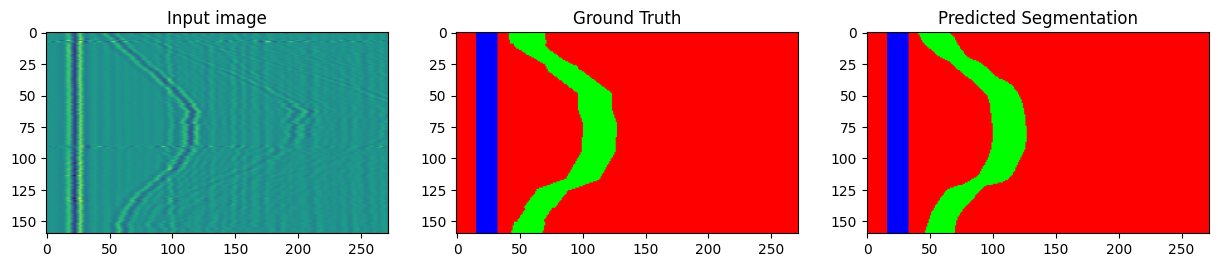

  0%|          | 0/54 [00:05<?, ?it/s]


In [22]:
for x,y in tqdm(dataloader):
    x = x.to('mps')
    y = y.to('mps')
    logits = model(x)[0]
    pred = torch.argmax(logits, dim=0)
    # pred = remove_padding(torch.argmax(logits, dim=0))
    print(pred.shape)
    print(y.shape)
    #print(y[0, 20, 25, :])

    pred = pred.cpu().detach().numpy()
    # Define RGB colors for each class
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])  # Red, Green, Blue

    # Convert class indices to RGB colors
    segmentation_mask = colors[pred]  # Shape: (H, W, 3)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(x[0].permute(1, 2, 0).cpu().detach().numpy())
    
    axs[0].set_title('Input image')

    axs[1].imshow(y[0].permute(1, 2, 0).cpu().detach().numpy())
    axs[1].set_title('Ground Truth')

    axs[2].imshow(segmentation_mask)
    axs[2].set_title('Predicted Segmentation')

    plt.show()

    

    break

In [23]:
file_path_X = 'X_test'
index = np.load('X_test/_index.npy')

dataset_test = patch_dataset_test(file_path_X,index,load_in_ram=True, numtype=torch.float32)

# test_loader = DataLoader(dataset_test, batch_size, shuffle=False, collate_fn=custom_collate)

test_loader = DataLoader(dataset_test, batch_size, shuffle=False)

  0%|          | 0/16 [00:00<?, ?it/s]

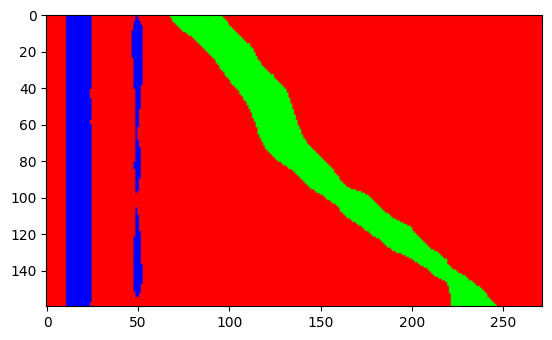

  0%|          | 0/16 [00:04<?, ?it/s]


In [25]:
model.to("mps")

for batch in tqdm(test_loader):
    x = batch
    x = x.to('mps')
    logits = model(x)[0]
    pred = torch.argmax(logits, dim=0)
    # pred = remove_padding(pred)
    pred = pred.cpu().detach().numpy()
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])  # Red, Green, Blue
    segmentation_mask = colors[pred]  # Shape: (H, W, 3)
    plt.imshow(segmentation_mask)
    plt.show()
    break

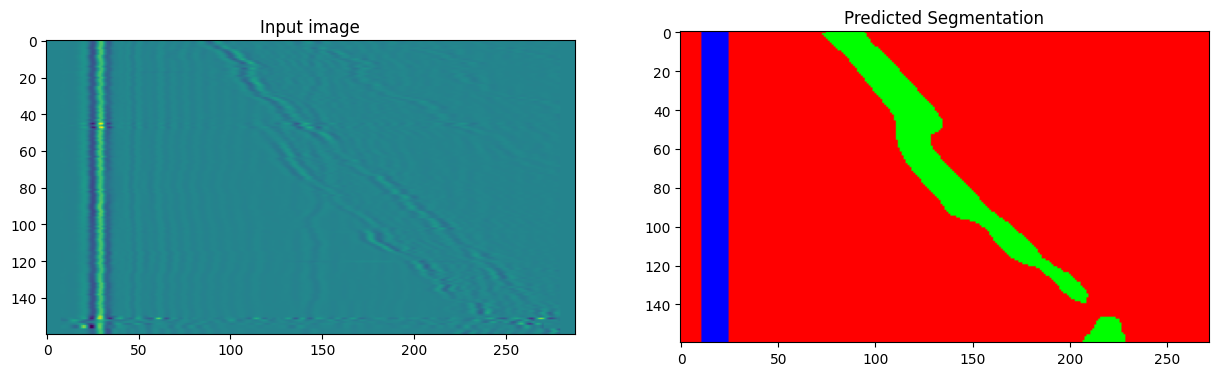

In [57]:
model = smp.Unet(
    encoder_name="resnet34",       
    encoder_weights="imagenet",    
    in_channels=1,                 
    classes=3,           
)

model.load_state_dict(torch.load('models/pretrained-resnet34-imagenet.pth', weights_only=True))

model.to('mps')
model.eval()

for x in dataset_test:
    x = pad_to_size(x, target_height=160, target_width=288)
    x = x.to('mps')
    x.unsqueeze_(0)
    logits = model(x)[0]
    pred = torch.argmax(logits, dim=0)
    pred = remove_padding(pred)
    
    pred = pred.cpu().detach().numpy()
    # Define RGB colors for each class
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])  # Red, Green, Blue

    # Convert class indices to RGB colors
    segmentation_mask = colors[pred]  # Shape: (H, W, 3)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].imshow(x[0].permute(1, 2, 0).cpu().detach().numpy())
    
    axs[0].set_title('Input image')


    axs[1].imshow(segmentation_mask)
    axs[1].set_title('Predicted Segmentation')

    plt.show()

    break

In [26]:
import os

model.eval()
predictions = []

os.makedirs('predictions', exist_ok=True)

with torch.no_grad():
    for i in range(len(dataset_test)):
        x = torch.from_numpy(np.load(file_path_X+'/'+index[i])).unsqueeze(0).to(torch.float32)
        # x = pad_to_size(x, target_height=160, target_width=288)
        x = x.to('mps')
        logits = model(x.unsqueeze(0))[0]
        pred = torch.argmax(logits, dim=0)
        # pred = remove_padding(pred)
        pred = pred.cpu().detach().numpy()
        # pred_custom = custom_output(logits,10)
        # pred_custom = pred_custom.cpu().detach()
        # pred_custom = pred_custom.numpy()
        predictions.append(pred)
        
        # Save the prediction
        filename = os.path.basename(index[i])
        np.save(f'predictions/{filename}', pred)

predictions = np.array(predictions)
print(predictions.shape)  # Should print (num_images, 160, 272)

(972, 160, 272)


In [27]:
from pathlib import Path
import pandas as pd
import numpy as np

size_labels = 272
predictions = {'test':{}}
for phase in predictions.keys():
    img_save_dir = Path('predictions')
    for img_path in img_save_dir.glob('*.npy'):
        name = img_path.stem
        if name in predictions[phase]:
            continue
        prediction = np.load(img_path)
        if prediction.shape[1]!=size_labels:
            prediction_aux = -1+np.zeros(160*size_labels) # Adding padding to ensure all masks have the same size
            prediction_aux[0:160*160] = prediction.flatten()
        else:
            prediction_aux = prediction.flatten()
        predictions[phase].update({name:prediction_aux})
pd.DataFrame(predictions['test'], dtype='int').T.to_csv(Path(f'submits/pretrained-deeplabv3-30e-default-resnet34-imagenet.csv'))